### First, Setup the local cluster

In [1]:
from dask.distributed import Client

client = Client(n_workers=4)
client

d:\Anaconda3\Anaconda3\Lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 8823 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8823/status,
Dashboard: http://127.0.0.1:8823/status,Workers: 4
Total threads: 32,Total memory: 31.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:8824,Workers: 4
Dashboard: http://127.0.0.1:8823/status,Total threads: 32
Started: Just now,Total memory: 31.18 GiB
Comm: tcp://127.0.0.1:8846,Total threads: 8
Dashboard: http://127.0.0.1:8853/status,Memory: 7.80 GiB
Nanny: tcp://127.0.0.1:8827,


**Dask Dashboard**

*Please be aware that Google Colab operates on a remote machine for computation; thus, you should use the version of Jupyter Notebook installed on your own computer to access the dashboard.*

Dask Distributed provides a useful Dashboard to visualize the state of your cluster and computations.
Simply click on the dashboard link displayed in the Client details above: http://127.0.0.1:8787/status. It will open a new browser tab with the Dashboard.

We can focus in the status tab which consists of **"Task Stream"**, **"Progress Bar"**, and **"Worker Memory"**

### 1. Dask Arrays: Parallelized Numpy

Dask Array provides a portion of the NumPy ndarray interface by utilizing blocked algorithms, which divide a large array into multiple smaller arrays. It enables computations on arrays that exceed memory capacity by leveraging all available CPU cores.

This section enables us to grasp the underlying mechanisms by implementing some blocked algorithms from scratch.

#### 1.1 Blocked Algorithms

In [2]:
import numpy as np
import dask.array as da

To begin, we first create a one-dimensional array containing 20 elements.

In [3]:
arr = np.ones(20)
arr

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

To calculate the total of all the elements in the array, we can use the `sum()` function.

In [4]:
print(arr.sum())

20.0


However, we can also calculate the sum of the first half of the array and the second half in parallel.

In [5]:
print(arr[:int(len(arr)/2)].sum() + arr[int(len(arr)/2):].sum())

20.0


Keep in mind that each sum in the above computation is entirely independent, allowing them to be processed in parallel.

To achieve this with a Dask array, we need to define our "slices" by specifying the number of elements we want per block using the variable `chunks`.

In [6]:
arr_da = da.ones(20, chunks=10)
arr_da

dask.array<ones_like, shape=(20,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>

From the output above, we can observe that there are two blocks. By specifying chunks=10, we indicate that each block contains 10 elements.

In [7]:
arr_da_sum = arr_da.sum()
arr_da_sum

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

The result did not display any output. Since Dask employs lazy evaluation, it first constructs the representation's structure. We  often referred this as lazy output.

#### 1.2 Task Graph

In Dask, we utilize task scheduling to divide our program into smaller computational tasks.

These tasks are represented as nodes in a graph, with edges connecting nodes when one task relies on data generated by another.

A task scheduler is then employed to execute this graph, ensuring that data dependencies are maintained while maximizing parallelism, allowing multiple independent tasks to run simultaneously.

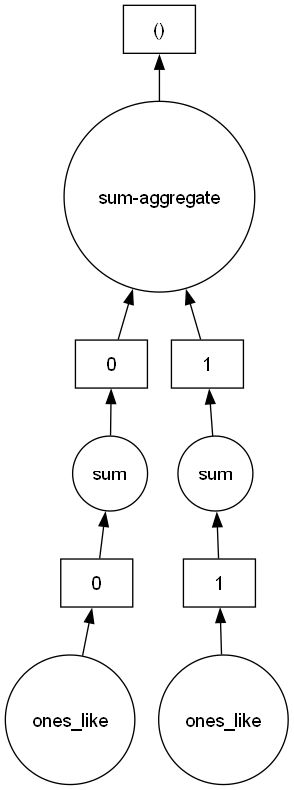

In [8]:
arr_da_sum.visualize()

In [9]:
print(arr_da_sum.compute())

20.0


#### 1.3 Performance Comparison (20 marks)

Next, we will create a larger array (20000 x 20000) filled with normally distributed values and calculate the mean along one of its axes. We will then compare the performance of NumPy and Dask arrays.

In [10]:
%%time
large_arr = np.random.normal(20, 0.1, size=(20000, 20000))
large_arr_mean = large_arr.mean(axis=0)
large_arr_mean

CPU times: total: 13.9 s
Wall time: 13.2 s


array([19.99928791, 19.9997869 , 19.99844282, ..., 19.99921512,
       20.00039571, 19.99959805])

Next, we will explore the Dask implementation.

In [11]:
dask_arr = da.random.normal(20, 0.1, size=(20000, 20000), chunks=(2000,2000))
dask_arr

dask.array<normal, shape=(20000, 20000), dtype=float64, chunksize=(2000, 2000), chunktype=numpy.ndarray>

In [12]:
dask_arr_mean = dask_arr.mean(axis=0)
dask_arr_mean

dask.array<mean_agg-aggregate, shape=(20000,), dtype=float64, chunksize=(2000,), chunktype=numpy.ndarray>

We can now compare the performance of the NumPy and Dask implementations.

In [13]:
%%time
dask_arr = da.random.normal(20, 0.1, size=(20000, 20000), chunks=(2000,2000))
dask_arr_mean = dask_arr.mean(axis=0).compute()

CPU times: total: 422 ms
Wall time: 1.27 s


In [14]:
#TODO 1: Repeat the tasks above with the chunks size (10000,10000)
dask_arr_10000 = da.random.normal(20, 0.1, size = (20000, 20000), chunks = (10000,10000))
dask_arr_10000_mean = dask_arr.mean(axis = 0)

In [15]:
%%time
dask_arr_10000 = da.random.normal(20, 0.1, size = (20000, 20000), chunks = (2000,2000))
dask_arr_10000_mean = dask_arr_10000.mean(axis = 0).compute()

CPU times: total: 484 ms
Wall time: 1.03 s


In [16]:
#TODO 2: Repeat the tasks above with the chunks size (30,30)
#        Using CoLab for this execution might consume all available memory and cause the session to crash.
dask_arr_30 = da.random.normal(20, 0.1, size = (20000, 20000), chunks = (30,30))
dask_arr_30_mean = dask_arr_30.mean(axis = 0)

In [17]:
%%time
dask_arr_10000 = da.random.normal(20, 0.1, size = (20000, 20000), chunks = (2000,2000))
dask_arr_10000_mean = dask_arr_10000.mean(axis = 0).compute()

CPU times: total: 422 ms
Wall time: 932 ms


In [18]:
#TODO 3: Let's calculate the sum of dask_arr and its transpose (dask_arr.T), (10 marks)
#.       and then determine the mean of that sum.
dask_arr_sum = dask_arr + dask_arr.T
dask_arr_sum_mean = dask_arr_sum.mean()
print(dask_arr_sum.compute())
print(dask_arr_sum_mean.compute())

[[39.94525808 39.9571572  39.98070688 ... 40.01967644 39.98813309
  40.06898153]
 [39.9571572  40.01213515 40.05844407 ... 39.97786259 39.85720765
  39.87538515]
 [39.98070688 40.05844407 39.90847092 ... 39.87132547 39.97055165
  39.95920138]
 ...
 [40.01967644 39.97786259 39.87132547 ... 39.86709717 40.10598027
  39.844225  ]
 [39.98813309 39.85720765 39.97055165 ... 40.10598027 40.20286095
  39.92071694]
 [40.06898153 39.87538515 39.95920138 ... 39.844225   39.92071694
  40.11298767]]
40.00000995025166


**The size of the chunk is important.**

> A common challenge when starting with Dask arrays is figuring out what constitutes an appropriate chunk size. But what is considered a good size, and how can we determine it?



We can view Dask arrays as a large structure made up of smaller chunks, with each chunk typically being a single NumPy array. These chunks are organized together to create a larger Dask array.

If you have a Dask array and want to learn more about its chunks and their sizes, you can access this information using the chunksize and chunks attributes.

Additionally, if you're using a Jupyter notebook, you can visualize the Dask array through its HTML representation.



In [19]:
dask_arr = da.random.random((1000, 1000, 1000))
dask_arr

dask.array<random_sample, shape=(1000, 1000, 1000), dtype=float64, chunksize=(255, 255, 255), chunktype=numpy.ndarray>

Notice that if we don't specify the chunk sizes, Dask defaults to chunks='auto', which optimizes the chunk sizes automatically.

In [20]:
#dask_arr.chunksize shows the largest chunk size.

dask_arr.chunksize

(255, 255, 255)

In [21]:
# if your array have irregular chunks,
# darr.chunks will show you the explicit sizes of all the chunks
# along all the dimensions of your dask array.

dask_arr.chunks

((255, 255, 255, 235), (255, 255, 255, 235), (255, 255, 255, 235))

Let’s adjust our example to further explore chunking. We can rechunk our array as follows:

In [22]:
dask_arr = dask_arr.rechunk({0: -1, 1: 100, 2: "auto"})
dask_arr

dask.array<rechunk-merge, shape=(1000, 1000, 1000), dtype=float64, chunksize=(1000, 100, 167), chunktype=numpy.ndarray>

In [23]:
dask_arr.chunksize

(1000, 100, 167)

In [24]:
dask_arr.chunks

((1000,),
 (100, 100, 100, 100, 100, 100, 100, 100, 100, 100),
 (167, 167, 167, 167, 167, 165))

<font color="red">TODO #4: Think about what does -1 mean when specify as the chunk on a certain axis (10 marks)</font>

<font color="red">answer: -1 means no chunking on the axis</font>

**Too small is a problem**

If your chunks are too small, each task performs very little actual work, and the overhead involved in coordinating these tasks leads to an inefficient process.

**Too big is a problem**

If your chunks are too large, it can lead to problems, as you may run out of memory. When too much data is loaded into memory, Dask workers will begin to spill data to disk to prevent crashes. This spilling process significantly slows down performance due to the additional read and write operations required on the disk. This is certainly a situation we want to avoid.

**In general, a chunk size between 100MB and 1GB is good !**

#### 1.4 Example of chunked data with Zarr

Zarr is an open-source library designed for the storage of large, multi-dimensional arrays in a format that is efficient and scalable. It allows users to work with data that exceeds memory limits by providing a chunked storage model, enabling seamless access to data on disk or cloud storage.

First, we may need to install the module.

In [25]:
!pip install zarr

**Random Dataset Generation**

The cell below utilizes the Dask library to create and store large random arrays in the Zarr format.

It defines a total size of 200 million elements and generates two Dask arrays filled with random numbers:

- one with chunks of 6,250,000 elements
- another with smaller chunks of 10,000 elements.

The arrays are then saved to a specified directory in the Zarr format, allowing efficient storage and retrieval of large datasets.

In [26]:
import dask.array as da
import random
import os
import zarr
size = 200_000_000
data_dir = "./zarr_data"
random_arr = da.random.random(size=(size,), chunks=(6250000,))
random_arr_small_chunks = da.random.random(size=(size,), chunks=(10000,))
random_arr.to_zarr(os.path.join(data_dir, "random.zarr"))
random_arr_small_chunks.to_zarr(os.path.join(data_dir, "random_sc.zarr"))

d:\Anaconda3\Anaconda3\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 54.76 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Initially, load the Zarr file with chunks of 6,250,000.

In [27]:
arr_zarr = da.from_zarr("zarr_data/random.zarr")

In [28]:
arr_zarr.chunks

((6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000,
  6250000),)

Note that the array is already chunked, and we didn't need to specify anything during the loading process. Additionally, observe that the chunks have a good size. Now, let's compute the mean and see how long it takes to execute.

In [29]:
arr_zarr

dask.array<from-zarr, shape=(200000000,), dtype=float64, chunksize=(6250000,), chunktype=numpy.ndarray>

In [30]:
%%time
arr_zarr.mean().compute()

CPU times: total: 141 ms
Wall time: 879 ms


np.float64(0.4999923075804726)

Let’s load another example that has a significantly smaller chunk size.

In [31]:
arr_zarr_smaller_chunks = da.from_zarr("zarr_data/random_sc.zarr")
arr_zarr_smaller_chunks

dask.array<from-zarr, shape=(200000000,), dtype=float64, chunksize=(10000,), chunktype=numpy.ndarray>

In [32]:
%%time
arr_zarr_smaller_chunks.mean().compute()

CPU times: total: 29.5 s
Wall time: 40 s


np.float64(0.49997784171614124)

#### 2.1 Advance Block Algorithm (map_blocks) (30 marks)

So far, we have only utilized the default API, such as sum() and mean(), to perform calculations in parallel. In this section, we aim to implement a custom function on our data chunks, allowing the customized function to be executed in parallel.

In this section, we will investigate how to utilize `map_blocks()` to apply a function across all blocks of a Dask array. Our goal is to calculate the number of prime numbers in a specified 8 x 8 array in parallel.

You can find detailed information about map_blocks in the Dask documentation at the following link: [Dask map_blocks Documentation](https://docs.dask.org/en/stable/generated/dask.array.map_blocks.html). This resource provides comprehensive guidance on how to use map_blocks effectively with Dask arrays.

First, we will define a 2D array of size 8x8 as follows.

In [33]:
data = [[ 4,  7, 12, 15, 23, 28, 31, 36],
 [ 9, 11, 17, 19, 22, 25, 29, 33],
 [ 8, 13, 16, 21, 27, 30, 37, 41],
 [14, 18, 24, 26, 32, 35, 39, 43],
 [ 5, 10, 20, 34, 38, 42, 47, 50],
 [ 6, 45, 49, 51, 53, 57, 59, 61],
 [ 2,  3, 44, 46, 52, 55, 58, 62],
 [ 1, 54, 56, 60, 63, 64, 67, 71]]

Task 1: Use the Dask library to convert the above 8x8 array into a Dask array with a specified chunk size

In [34]:
#TODO 5.1: Use the Dask library to convert the above 8x8 array into a Dask array with a specified chunk size
da_data = da.from_array(data, chunks=(4,4))
da_data

dask.array<array, shape=(8, 8), dtype=int64, chunksize=(4, 4), chunktype=numpy.ndarray>

Task 2: Since we will be calculating the number of prime numbers in the provided array, we need to define two Python functions:

- `Prime-Checking Function`: This function will determine whether a given integer is prime.
- `count_primes_block Function`: This function will utilize the prime-checking function to count the number of prime numbers in each chunk.

It is important to note that the function we request map_blocks to call must return an output of the same size. For instance, if the input chunk is a 2D array with a shape of (4, 4), the output must also maintain this two-dimensional format.

In [35]:
#TODO 5.2: Write a Prime-Checking Function:
#      Create a Python function is_prime(n) that returns True if n is a prime number and False otherwise.
def isPrime(n):
  if n < 2:
    return False
  for i in range(2, int(n / 2) + 1):
    if n % i == 0:
      return False
  return True

In [36]:
#TODO 5.3: Write a count_primes_block Function:
#          utilize the prime-checking function to count the number of prime numbers in each chunk.
def count_primes_block(block):
  count = 0
  for row in block:
    for x in row:
      if isPrime(x):
        count += 1
  return np.array([[count]])

Task 3: Next, we can use the `count_primes_block` and `isPrime` functions to apply them to each element in the Dask array using `da.map_blocks` to compute the total number of prime numbers.

In [37]:
#TODO 5.4: Apply the count_primes_block and isPrime function to each element in the Dask array using da.map_blocks.
prime_counts = da_data.map_blocks(count_primes_block).compute()
total_primes = prime_counts.sum()
print(total_primes)

20


#### 2.2 Advance Block Algorithm (map_overlay) (50 marks)

Until now, we've only considered computations that do not depend on other chunks. For instance, when calculating the sum of an array, there is no interdependence among different chunks.

However, what happens when a computation requires data from neighboring chunks?

Consider a 4 x 4 chunk represented as follows:

```
1  2  3  4
5  6  7  8
9 10 11 12
13 14 15 16
```

If we divide this chunk into four (2 x 2) smaller chunks, some operations may need data from adjacent chunks.

For example, if we want to determine the significant difference between a value and its neighbors, let's take data[1][1]. The neighbors are 2, 5, 7, and 10, where 2 and 5 are in the same chunk, while 7 and 10 belong to another chunk.

In this scenario, how can we achieve this?

map_overlap is a function provided by Dask that allows you to perform computations on large arrays while managing dependencies between adjacent chunks. It is particularly useful when operations require access to data from neighboring chunks, as it ensures that each chunk has overlapping data from its neighbors.

If you have a 2D array and want to compute the maximum difference between a value and its neighbors, map_overlap can be used to extend the boundaries of each chunk to include the necessary data from adjacent chunks, enabling accurate calculations.

This function is an essential tool in Dask for handling computations that involve interdependencies between chunks, making it easier to work with large datasets in a distributed environment.

You can find detailed information about map_overlap in the Dask documentation at the following link: [Dask map_overlay Documentation](https://docs.dask.org/en/latest/generated/dask.array.overlap.map_overlap.html).

In this section, we will perform Weighted Grid Summation. We have a 10x10 integer array, and our goal is to compute the weighted sum for each cell. The weighted sum for a cell is determined by adding its own value to the values of its immediate neighbors—those located above, below, to the left, right, and diagonally. Additionally, the values of  cells will be weighted twice as much as those of the neighboring cells.

We will utilize Dask to parallelize the computation across the grid. The output will present the weighted sums for all cells in a clear format.

Goals of this exercise:

- Learn to manipulate a 2D grid using Dask arrays.
- Handle edge cases (boundaries and corners) in grid computations.
- Apply weighted summation in a parallelized context.

You have a 10x10 grid of integers, and your tasks are as follows:

- Convert the grid to a Dask array with chunks (e.g., 5x5).
- For each cell, compute the weighted sum:

- The cell’s own value is weighted by 2.
Each neighbor’s value (up, down, left, right, diagonals) is weighted by 1.
- Corner cells have 3 neighbors; edge cells have 5, the others have 8.

- Output the weighted sums for each cells.

First, we will define a 2D array of size 10x10 as follows

In [38]:
grid = [[6, 3, 7, 4, 6, 9, 2, 6, 7, 4],
       [3, 7, 7, 2, 5, 4, 1, 7, 5, 1],
       [4, 0, 9, 5, 8, 0, 9, 2, 6, 3],
       [8, 2, 4, 2, 6, 4, 8, 6, 1, 3],
       [8, 1, 9, 8, 9, 4, 1, 3, 6, 7],
       [2, 0, 3, 1, 7, 3, 1, 5, 5, 9],
       [3, 5, 1, 9, 1, 9, 3, 7, 6, 8],
       [7, 4, 1, 4, 7, 9, 8, 8, 0, 8],
       [6, 8, 7, 0, 7, 7, 2, 0, 7, 2],
       [2, 0, 4, 9, 6, 9, 8, 6, 8, 7]]

Task 1: Use the Dask library to convert the above 10x10 array into a Dask array with a specified chunk size

In [39]:
#TODO 6.1: Use the Dask library to convert the above 10x10 array into a Dask array with a specified chunk size
dask_grid = da.from_array(grid, chunks=(5,5))
dask_grid

dask.array<array, shape=(10, 10), dtype=int64, chunksize=(5, 5), chunktype=numpy.ndarray>

Task 2: Create a function that returns the subarray of weighted sums for each chunk of the array.

In [40]:
#TODO 6.2: Create a function that returns the subarray of weighted sums for each chunk of the array.
def compute_weighted_sums(chunk, block_info = None):
  if chunk.shape[0] < 5 or chunk.shape[1] < 5:
    return np.zeros((0, 0), dtype = chunk.dtype)
  print(chunk.shape)
  result_shape = (chunk.shape[0] + 1, chunk.shape[1] + 1)
  result = np.zeros(shape = result_shape, dtype = chunk.dtype)
  for i in range(1, chunk.shape[0]):
    for j in range(1, chunk.shape[1]):
      result[i, j] = (chunk[i - 2, j - 2] + chunk[i - 2, j - 1] + chunk[i - 2, j] +
                     chunk[i - 1, j - 2] + chunk[i - 1, j - 1] * 2 + chunk[i - 1, j] +
                     chunk[i, j - 2] + chunk[i, j - 1] + chunk[i, j])
  return result[1:, 1:]

Task 3: Call map_overlap on compute_weighted_sums to perform the calculation for the Weighted Grid Summation.

In [41]:
#TODO 6.3: Call map_overlap on compute_weighted_sums to perform the calculation for the Weighted Grid Summation.
result = dask_grid.map_overlap(compute_weighted_sums, depth = 1, boundary = 0).compute()
print(result)

[[25 36 37 35 36 36 31 34 37 21]
 [26 53 51 55 48 48 41 52 46 27]
 [28 44 47 53 44 45 50 47 40 22]
 [31 47 44 62 52 53 45 48 38 29]
 [29 38 39 57 53 47 36 39 51 38]
 [21 32 40 49 58 41 37 42 61 50]
 [24 31 29 43 51 57 56 50 62 44]
 [40 46 40 41 60 62 61 49 46 39]
 [33 47 44 45 65 70 59 47 53 34]
 [18 27 32 42 44 48 40 37 38 31]]


It is a best practice to shut down any Dask Cluster you have created after completing your tasks.

In [42]:
client.shutdown()